In [1]:
import torch
from torch import nn
from torch.utils.data import random_split, DataLoader 
from torchvision import transforms, datasets
from torchvision.transforms import v2
import os
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
from tqdm import tqdm
from sklearn import metrics
from torch import optim
import logging
from torchsummary import summary
import seaborn as sns

logging.basicConfig(encoding='utf-8')

DEVICE = 'cuda' if torch.cuda.is_available() else "cpu"
print('DEVICE = ', DEVICE)

c:\Users\nguye\anaconda3\envs\torch\lib\site-packages\torchvision\datapoints\__init__.py:12: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may have in this issue: https://github.com/pytorch/vision/issues/6753, and you can also check out https://github.com/pytorch/vision/issues/7319 to learn more about the APIs that we suspect might involve future changes. You can silence this warning by calling torchvision.disable_beta_transforms_warning().
  warnings.warn(_BETA_TRANSFORMS_WARNING)
c:\Users\nguye\anaconda3\envs\torch\lib\site-packages\torchvision\transforms\v2\__init__.py:54: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may

DEVICE =  cuda


In [2]:
#PARAMS
BATCH_SIZE = 32 
root = os.getcwd()
dataset_path = os.path.join(root, 'dataset', 'cnn_dataset')
assert os.path.exists(dataset_path), f'path to dataset does not exist {dataset_path}'


In [5]:
custom_transform = v2.Compose([
    v2.ToTensor(),
    # v2.Resize((224,224), antialias=True),
    # v2.RandomHorizontalFlip(0.5),
    # v2.RandomRotation(0.5),
    # v2.ToDtype(torch.float32),
    # v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# train_dataset = datasets.ImageFolder(root = './cnn_dataset', transform = custom_transform)
# train_dataloader =  DataLoader(train_dataset, shuffle= True, num_workers= 4, batch_size = BATCH_SIZE)
# print('train_dataloader len = ',len(train_dataloader))

# features, labels = next(iter(train_dataloader))
# print('features shape = ', features.shape)
# print('labels shape = ', labels.shape)

class_dict = {
    0: 'Dog',
    1: 'Food',
    2: 'Vehicle'
}

c:\Users\nguye\anaconda3\envs\torch\lib\site-packages\torchvision\transforms\v2\_deprecated.py:41: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `transforms.Compose([transforms.ToImageTensor(), transforms.ConvertImageDtype()])`.
  warnings.warn(


In [6]:
custom_transform = v2.Compose([
    v2.ToTensor(),
    # v2.Resize((224,224), antialias=True),
    # v2.RandomHorizontalFlip(0.5),
    # v2.RandomRotation(0.5),
    # v2.ToDtype(torch.float32),
    # v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
dataset = datasets.ImageFolder(root = dataset_path, transform = custom_transform)
total_len = len(dataset)
train_ratio = 0.7
valid_ratio = 0.15
test_ratio = 0.15

train_size = int(total_len * train_ratio)
valid_size = int(total_len * valid_ratio)
test_size = int(total_len * test_ratio)

print('total len = ', total_len)
print()

train_dataset, valid_dataset, test_dataset = random_split(dataset, [train_size, valid_size, test_size])
print('train dataset len = ', len(train_dataset))
print('valid dataset len = ', len(valid_dataset))
print('test dataset len = ', len(test_dataset))

train_dataloader =  DataLoader(train_dataset, shuffle= True, batch_size = BATCH_SIZE)
val_dataloader =  DataLoader(valid_dataset, shuffle= True, batch_size = BATCH_SIZE)
test_dataloader =  DataLoader(test_dataset, shuffle= True, batch_size = BATCH_SIZE)

total len =  30000

train dataset len =  21000
valid dataset len =  4500
test dataset len =  4500


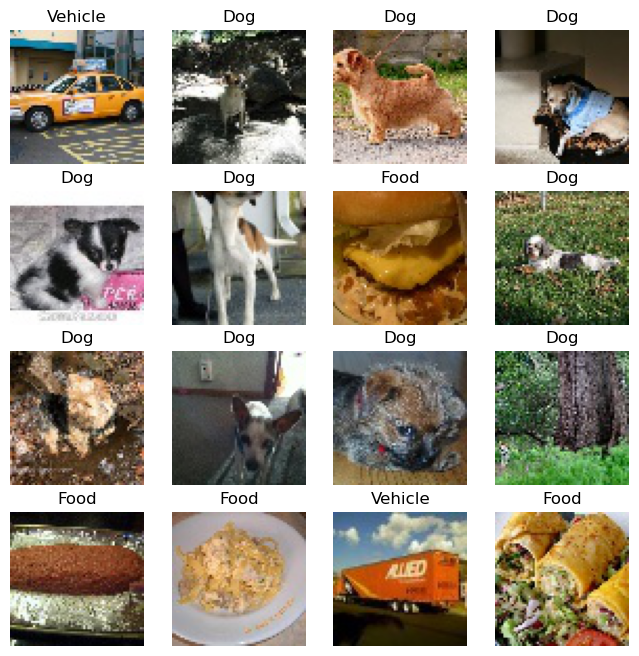

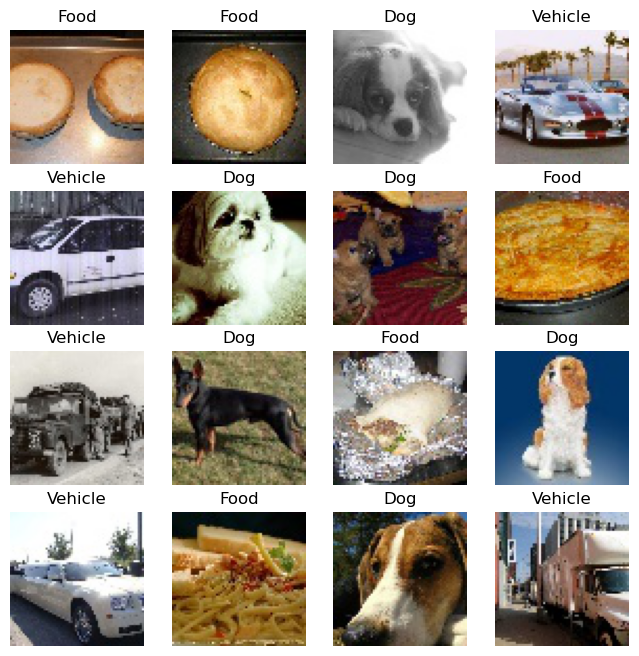

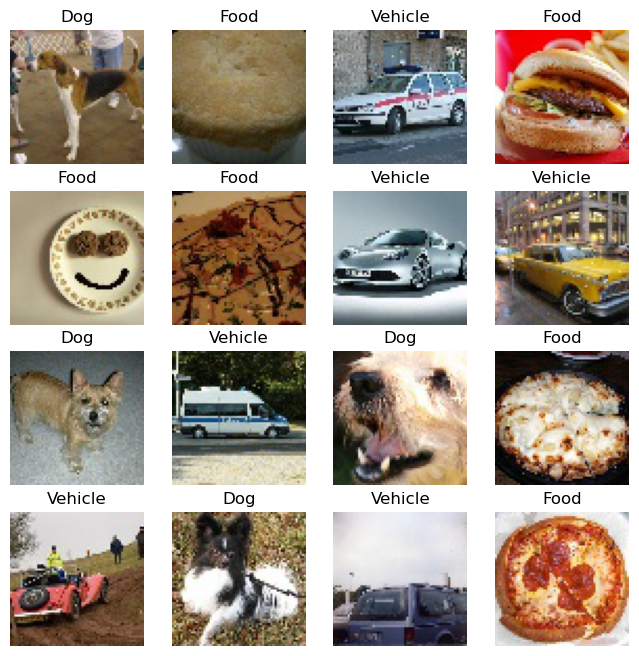

In [7]:
def sample_images(dataloader):
    features, labels = next(iter(dataloader))

    figure = plt.figure(figsize=(8,8))
    for i in range(16):
        figure.add_subplot(4, 4, i + 1)
        plt.imshow(np.transpose(features[i], (1,2,0)))
        plt.axis('off')
        plt.title(class_dict[labels[i].item()])

    plt.show()

sample_images(train_dataloader)
sample_images(val_dataloader)
sample_images(test_dataloader)

### Trainer

In [6]:
class Trainer():
    def __init__(self, log_level = logging.DEBUG):
        self.device = 'cuda' if torch.cuda.is_available() else "cpu"
        self.logger = logging.getLogger()
        self.logger.setLevel(log_level)
        self.logger.info('created trainer')

    def prepare_model(self, model, device):
        model.to(device)
        return model
    
    def prepare_batch(self, batch, device):
        features, labels = batch
        features = features.to(device)
        labels = labels.type(torch.LongTensor).to(device)
        return features, labels
    
    def score(self, score_fn, model, dataloader, device, criterion = None, name ='', **kwargs):
        y_pred = np.array([])
        y = np.array([])
        loop = tqdm(dataloader)
        loop.set_description(f'evaluating score {name}...')
        running_loss = 0.0 if criterion != None else None
        for batch in loop: 
            features, labels = self.prepare_batch(batch, device)
            outputs = model(features)

            #get loss values if criterion not None 
            if criterion:
                loss = criterion(outputs, labels)
                running_loss += loss.item()

            outputs = torch.argmax(outputs, dim = 1).detach().cpu().numpy().reshape(-1)
            labels = labels.detach().cpu().numpy().reshape(-1)
            y_pred = np.concatenate((y_pred, outputs))
            y = np.concatenate((y, labels))
        
        return score_fn(y_pred, y, **kwargs), running_loss 

    def confusion_matrix(self, model, dataloader, device, **kwwargs):
        y_pred = np.array([])
        y = np.array([])
        for batch in dataloader:
            features, labels = self.prepare_batch(batch, device)
            outputs = model(features)
            outputs = torch.argmax(outputs, dim = 1).detach().cpu().numpy().reshape(-1)
            labels = labels.detach().cpu().numpy().reshape(-1)
            y_pred = np.concatenate((y_pred, outputs))
            y = np.concatenate((y, labels))

        cm = metrics.confusion_matrix(y_pred, y)
        sns.heatmap(cm, annot = True)
    
    def performance_plot(self, history):
        train_loss =[]
        val_loss =[]
        test_loss =[]
        train_acc = []
        val_acc = []
        test_acc = []

        for hist in history:
            train_loss.append(hist['train_loss'])
            val_loss.append(hist['val_loss'])
            test_loss.append(hist['test_loss'])
            train_acc.append(hist['train_accuracy'])
            val_acc.append(hist['val_accuracy'])
            test_acc.append(hist['test_accuracy'])
        
        fig, (ax1, ax2) = plt.subplots(1,2, figsize = (10,5))
        e = list(range(len(history)))
        
        sns.lineplot(x = e, y = train_loss, label = 'train loss', ax = ax1)
        sns.lineplot(x = e, y = val_loss, label = 'val loss', ax = ax1)
        sns.lineplot(x = e, y = test_loss, label = 'test loss', ax = ax1)
        sns.lineplot(x = e, y = train_acc, label = 'train accuracy', ax = ax2)
        sns.lineplot(x = e, y = val_acc, label = 'val accuracy', ax = ax2)
        sns.lineplot(x = e, y = test_acc, label = 'test accuracy', ax = ax2)
        plt.show()
        

    def train(self, model, optim, criterion,  train_dataloader, val_dataloader, \
              test_dataloader, device = None, epochs = 10, save_path = None):

        if device == None:
            device = self.device

        self.logger.info(f"DEVICE = {device}")

        history = []
        self.logger.info('preparing model for training ... ')
        model = self.prepare_model(model, device)

        self.logger.info('training ... ')

        best_score = 0

        for e in range(epochs):
            loop = tqdm(train_dataloader)

            total_train_loss = 0
            total_valid_loss = 0
            total_test_loss = 0
            loop.set_description(f'training epoch {e}\t\t')

            y_pred = np.array([])
            y = np.array([])
            model.train()

            for batch in loop:
                features, labels = self.prepare_batch(batch, device)

                outputs = model(features)

                optim.zero_grad()
                loss = criterion(outputs, labels)
                loss.backward()
                optim.step()

                total_train_loss += loss.item()

            model.eval()
            train_accuracy, train_loss = self.score(metrics.accuracy_score, model, train_dataloader, device, criterion=criterion, name = 'train')
            val_accuracy, val_loss = self.score(metrics.accuracy_score, model, val_dataloader, device, criterion=criterion, name = 'valid')
            test_accuracy, test_loss = self.score(metrics.accuracy_score, model, test_dataloader, device, criterion=criterion, name = 'test')

            self.logger.debug(f'\n\
                            epoch = {e}\n\
                            =============\n\
                            train_loss = {train_loss:.2f}\n\
                            train_accuracy = {train_accuracy:.2f}\n\
                            val loss = {val_loss:.2f}\n\
                            valid_accuracy = {val_accuracy:.2f}\n\
                            test loss = {test_loss:.2f}\n\
                            test_accuracy = {test_accuracy:.2f}\n\
                            bets_accuracy = {best_score:.2f}\n\
                            ')
            history.append({
                'train_loss': train_loss,
                'train_accuracy': train_accuracy,
                'val_loss': val_loss,
                'val_accuracy': val_accuracy,
                'test_loss': test_loss,
                'test_accuracy': test_accuracy,
            })
            
            if best_score < test_accuracy:
                best_score = test_accuracy

                if save_path:
                    self.logger.info(f"saved best score model at checkpoint.{save_path}")
                    torch.save(model, 'checkpoint.' + save_path)

        self.logger.info("done training ...")

        return model, history 


### VGG13 baseline

In [9]:
def build_vgg13(num_class):
    model = nn.Sequential(
        nn.LazyConv2d(out_channels=64, kernel_size=3, padding = 1),
        nn.LazyConv2d(out_channels=64, kernel_size=3, padding = 1),
        # nn.BatchNorm2d(64),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride = 2),
        nn.LazyConv2d(out_channels=128, kernel_size=3, padding = 1),
        nn.LazyConv2d(out_channels=128, kernel_size=3, padding = 1),
        # nn.BatchNorm2d(128),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride = 2),
        nn.LazyConv2d(out_channels=256, kernel_size=3, padding = 1),
        nn.LazyConv2d(out_channels=256, kernel_size=3, padding = 1),
        # nn.BatchNorm2d(256),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2),
        nn.LazyConv2d(out_channels=512, kernel_size=3, padding = 1),
        nn.LazyConv2d(out_channels=512, kernel_size=3, padding = 1),
        # nn.BatchNorm2d(512),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride = 2),
        nn.LazyConv2d(out_channels=512, kernel_size=3, padding = 1),
        nn.LazyConv2d(out_channels=512, kernel_size=3, padding = 1),
        # nn.BatchNorm2d(512),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride = 2),
        nn.Dropout(0.5),
        nn.Flatten(),
        nn.LazyLinear(4096),
        nn.Dropout(0.5),
        nn.ReLU(),
        nn.LazyLinear(4096),
        nn.ReLU(),
        nn.LazyLinear(num_class),
    )
    return model

In [10]:
torch.cuda.empty_cache()

vgg13 = build_vgg13(num_class=3)
vgg13.to(DEVICE)
criterion = nn.CrossEntropyLoss()
optim = torch.optim.SGD(vgg13.parameters(), lr = 0.01)
trainer = Trainer()

vgg13,history = trainer.train(vgg13, optim, criterion, \
                              train_dataloader = train_dataloader, \
                              val_dataloader = val_dataloader, \
                              test_dataloader = test_dataloader, \
                              epochs = 5)

trainer.performance_plot(history)

torch.save(vgg13, 'vgg13.h5')

c:\Users\nguye\anaconda3\envs\torch\lib\site-packages\torch\nn\modules\lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '
INFO:root:created trainer
INFO:root:DEVICE = cuda
INFO:root:preparing model for training ... 
INFO:root:training ... 
evaluating score test...: 100%|██████████| 141/141 [00:03<00:00, 39.91it/s]
DEBUG:root:
                            epoch = 0
                            train_loss = 721.80
                            train_accuracy = 0.33
                            val loss = 154.92
                            valid_accuracy = 0.33
                            test loss = 154.93
                            test_accuracy = 0.33
                            bets_accuracy = 0.00
                            
training epoch 1		:  81%|████████  | 533/657 [00:23<00:05, 22.71it/s]

DEBUG:matplotlib.colorbar:locator: <matplotlib.ticker.AutoLocator object at 0x000002089AC46640>


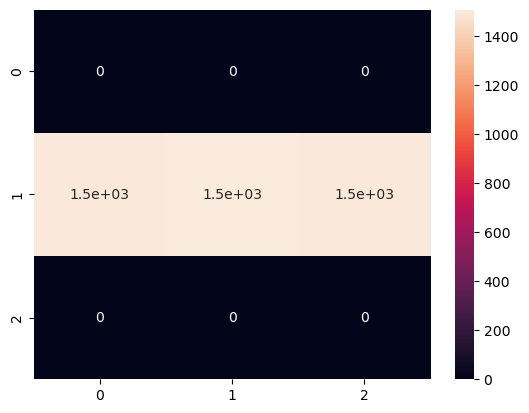

In [ ]:
# trainer = Trainer()
# vgg13 = torch.load('vgg13.h5')
trainer.confusion_matrix(vgg13, test_dataloader, DEVICE)

# Model with dropout


In [ ]:
#Added dropout after each batchnorm
def vgg13_with_dropout(num_class):
    model = nn.Sequential(
        nn.LazyConv2d(out_channels=64, kernel_size=3, padding = 1),
        nn.LazyConv2d(out_channels=64, kernel_size=3, padding = 1),
        nn.BatchNorm2d(64),
        nn.Dropout(0.1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride = 2),
        nn.LazyConv2d(out_channels=128, kernel_size=3, padding = 1),
        nn.LazyConv2d(out_channels=128, kernel_size=3, padding = 1),
        nn.BatchNorm2d(128),
        nn.Dropout(0.1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride = 2),
        nn.LazyConv2d(out_channels=256, kernel_size=3, padding = 1),
        nn.LazyConv2d(out_channels=256, kernel_size=3, padding = 1),
        nn.BatchNorm2d(256),
        nn.Dropout(0.1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2),
        nn.LazyConv2d(out_channels=512, kernel_size=3, padding = 1),
        nn.LazyConv2d(out_channels=512, kernel_size=3, padding = 1),
        nn.BatchNorm2d(512),
        nn.Dropout(0.1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride = 2),
        nn.LazyConv2d(out_channels=512, kernel_size=3, padding = 1),
        nn.LazyConv2d(out_channels=512, kernel_size=3, padding = 1),
        nn.BatchNorm2d(512),
        nn.Dropout(0.1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride = 2),
        nn.Dropout(0.5),
        nn.Flatten(),
        nn.LazyLinear(4096),
        nn.Dropout(0.5),
        nn.ReLU(),
        nn.LazyLinear(4096),
        nn.ReLU(),
        nn.LazyLinear(num_class),
    )
    return model

c:\Users\nguye\anaconda3\envs\torch\lib\site-packages\torch\nn\modules\lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '
INFO:root:created trainer
INFO:root:DEVICE = cuda
INFO:root:preparing model for training ... 
INFO:root:training ... 
evaluating score test...: 100%|██████████| 141/141 [00:03<00:00, 40.02it/s]
DEBUG:root:
                            epoch = 0
                            train_loss = 721.76
                            train_accuracy = 0.34
                            val loss = 154.92
                            valid_accuracy = 0.32
                            test loss = 154.90
                            test_accuracy = 0.33
                            bets_accuracy = 0.00
                            
evaluating score test...: 100%|██████████| 141/141 [00:03<00:00, 39.81it/s]
DEBUG:root:
         

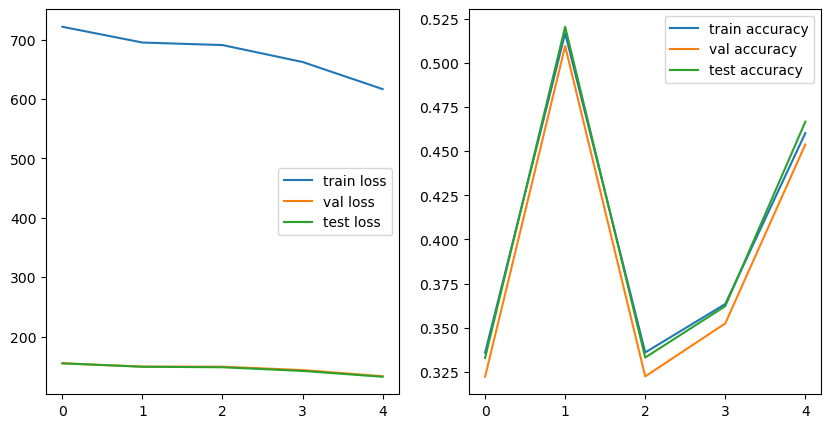

DEBUG:matplotlib.colorbar:locator: <matplotlib.ticker.AutoLocator object at 0x000002089ABA4D90>


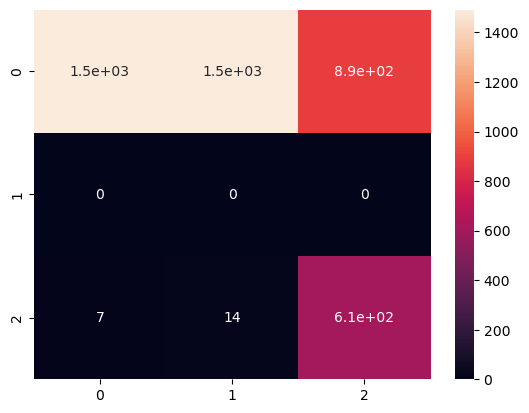

In [ ]:
torch.cuda.empty_cache()

vgg13 = vgg13_with_dropout(num_class=3)
vgg13.to(DEVICE)
criterion = nn.CrossEntropyLoss()
optim = torch.optim.SGD(vgg13.parameters(), lr = 0.01)
trainer = Trainer()

vgg13,history = trainer.train(vgg13, optim, criterion, \
                              train_dataloader = train_dataloader, \
                              val_dataloader = val_dataloader, \
                              test_dataloader = test_dataloader, \
                              epochs = 5)

trainer.performance_plot(history)

torch.save(vgg13, 'vgg13.h5')

trainer.confusion_matrix(vgg13, test_dataloader, DEVICE)

# VGG witth dropout + batch norm

In [ ]:
def vgg13_with_dropout_batchnorm(num_class):
    model = nn.Sequential(
        nn.LazyConv2d(out_channels=64, kernel_size=3, padding = 1),
        nn.LazyConv2d(out_channels=64, kernel_size=3, padding = 1),
        nn.BatchNorm2d(64),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride = 2),
        nn.LazyConv2d(out_channels=128, kernel_size=3, padding = 1),
        nn.LazyConv2d(out_channels=128, kernel_size=3, padding = 1),
        nn.BatchNorm2d(128),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride = 2),
        nn.LazyConv2d(out_channels=256, kernel_size=3, padding = 1),
        nn.LazyConv2d(out_channels=256, kernel_size=3, padding = 1),
        nn.BatchNorm2d(256),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2),
        nn.LazyConv2d(out_channels=512, kernel_size=3, padding = 1),
        nn.LazyConv2d(out_channels=512, kernel_size=3, padding = 1),
        nn.BatchNorm2d(512),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride = 2),
        nn.LazyConv2d(out_channels=512, kernel_size=3, padding = 1),
        nn.LazyConv2d(out_channels=512, kernel_size=3, padding = 1),
        nn.BatchNorm2d(512),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride = 2),
        nn.Dropout(0.5),
        nn.Flatten(),
        nn.LazyLinear(4096),
        nn.Dropout(0.5),
        nn.ReLU(),
        nn.LazyLinear(4096),
        nn.ReLU(),
        nn.LazyLinear(num_class),
    )
    return model

c:\Users\nguye\anaconda3\envs\torch\lib\site-packages\torch\nn\modules\lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '
INFO:root:created trainer
INFO:root:DEVICE = cuda
INFO:root:preparing model for training ... 
INFO:root:training ... 
evaluating score test...: 100%|██████████| 141/141 [00:03<00:00, 38.82it/s]
DEBUG:root:
                            epoch = 0
                            train_loss = 223.70
                            train_accuracy = 0.88
                            val loss = 47.73
                            valid_accuracy = 0.87
                            test loss = 53.25
                            test_accuracy = 0.87
                            bets_accuracy = 0.00
                            
evaluating score test...: 100%|██████████| 141/141 [00:03<00:00, 39.75it/s]
DEBUG:root:
           

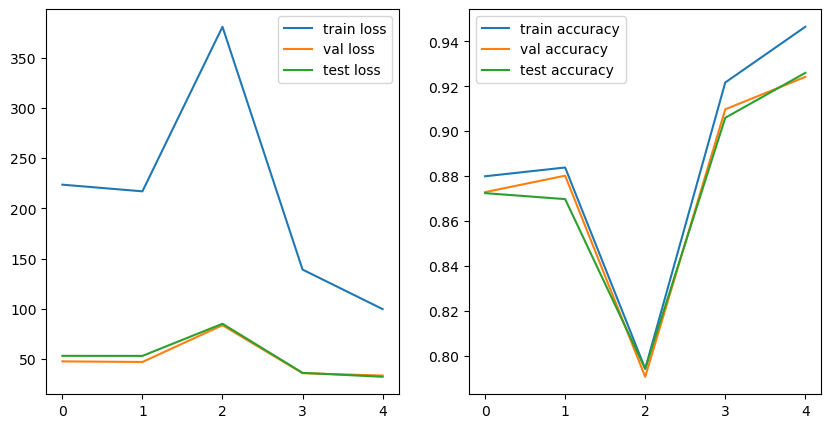

DEBUG:matplotlib.colorbar:locator: <matplotlib.ticker.AutoLocator object at 0x000002089B6BEEB0>


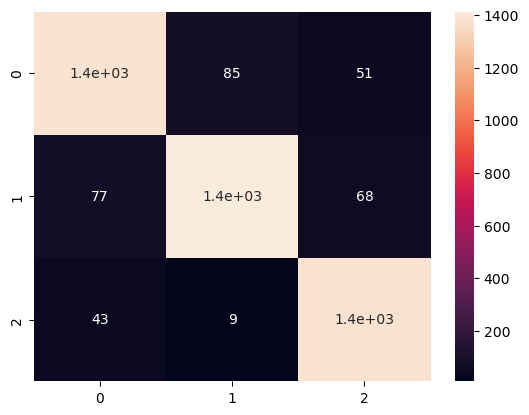

In [ ]:
torch.cuda.empty_cache()

vgg13 = vgg13_with_dropout_batchnorm(num_class=3)
vgg13.to(DEVICE)
criterion = nn.CrossEntropyLoss()
optim = torch.optim.SGD(vgg13.parameters(), lr = 0.01)
trainer = Trainer()

vgg13,history = trainer.train(vgg13, optim, criterion, \
                              train_dataloader = train_dataloader, \
                              val_dataloader = val_dataloader, \
                              test_dataloader = test_dataloader, \
                              epochs = 5)

trainer.performance_plot(history)

torch.save(vgg13, 'vgg13.h5')

trainer.confusion_matrix(vgg13, test_dataloader, DEVICE)

# VGG13 Dropout + Batchnorm + Augmentation

In [3]:
custom_transform = v2.Compose([
    v2.ToTensor(),
    v2.Resize((224,224), antialias=True),
    v2.RandomHorizontalFlip(0.5),
    v2.RandomRotation(0.5),
    v2.ToDtype(torch.float32),
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
dataset = datasets.ImageFolder(root = dataset_path, transform = custom_transform)
total_len = len(dataset)
train_ratio = 0.7
valid_ratio = 0.15
test_ratio = 0.15

train_size = int(total_len * train_ratio)
valid_size = int(total_len * valid_ratio)
test_size = int(total_len * test_ratio)

print('total len = ', total_len)
print()

train_dataset, valid_dataset, test_dataset = random_split(dataset, [train_size, valid_size, test_size])
print('train dataset len = ', len(train_dataset))
print('valid dataset len = ', len(valid_dataset))
print('test dataset len = ', len(test_dataset))

train_dataloader =  DataLoader(train_dataset, shuffle= True, batch_size = BATCH_SIZE)
val_dataloader =  DataLoader(valid_dataset, shuffle= True, batch_size = BATCH_SIZE)
test_dataloader =  DataLoader(test_dataset, shuffle= True, batch_size = BATCH_SIZE)

total len =  30000

train dataset len =  21000
valid dataset len =  4500
test dataset len =  4500


c:\Users\nguye\anaconda3\envs\torch\lib\site-packages\torchvision\transforms\v2\_deprecated.py:41: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `transforms.Compose([transforms.ToImageTensor(), transforms.ConvertImageDtype()])`.
  warnings.warn(


In [4]:
#Best model
def vgg13_with_dropout_batchnorm(num_class):
    model = nn.Sequential(
        nn.LazyConv2d(out_channels=64, kernel_size=3, padding = 1),
        nn.LazyConv2d(out_channels=64, kernel_size=3, padding = 1),
        nn.BatchNorm2d(64),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride = 2),
        nn.LazyConv2d(out_channels=128, kernel_size=3, padding = 1),
        nn.LazyConv2d(out_channels=128, kernel_size=3, padding = 1),
        nn.BatchNorm2d(128),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride = 2),
        nn.LazyConv2d(out_channels=256, kernel_size=3, padding = 1),
        nn.LazyConv2d(out_channels=256, kernel_size=3, padding = 1),
        nn.BatchNorm2d(256),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2),
        nn.LazyConv2d(out_channels=512, kernel_size=3, padding = 1),
        nn.LazyConv2d(out_channels=512, kernel_size=3, padding = 1),
        nn.BatchNorm2d(512),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride = 2),
        nn.LazyConv2d(out_channels=512, kernel_size=3, padding = 1),
        nn.LazyConv2d(out_channels=512, kernel_size=3, padding = 1),
        nn.BatchNorm2d(512),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride = 2),
        nn.Dropout(0.5),
        nn.Flatten(),
        nn.LazyLinear(4096),
        nn.Dropout(0.5),
        nn.ReLU(),
        nn.LazyLinear(4096),
        nn.ReLU(),
        nn.LazyLinear(num_class),
    )
    return model

c:\Users\nguye\anaconda3\envs\torch\lib\site-packages\torch\nn\modules\lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '
INFO:root:created trainer
INFO:root:DEVICE = cuda
INFO:root:preparing model for training ... 
INFO:root:training ... 
evaluating score test...: 100%|██████████| 141/141 [00:37<00:00,  3.79it/s]
DEBUG:root:
                            epoch = 0
                            train_loss = 248.12
                            train_accuracy = 0.86
                            val loss = 55.98
                            valid_accuracy = 0.85
                            test loss = 55.95
                            test_accuracy = 0.85
                            bets_accuracy = 0.00
                            
evaluating score test...: 100%|██████████| 141/141 [00:36<00:00,  3.84it/s]
DEBUG:root:
           

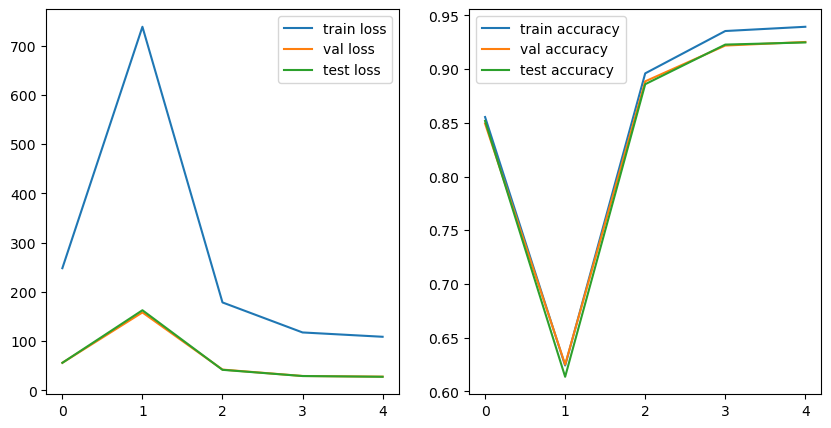

DEBUG:matplotlib.colorbar:locator: <matplotlib.ticker.AutoLocator object at 0x000001969CE11850>


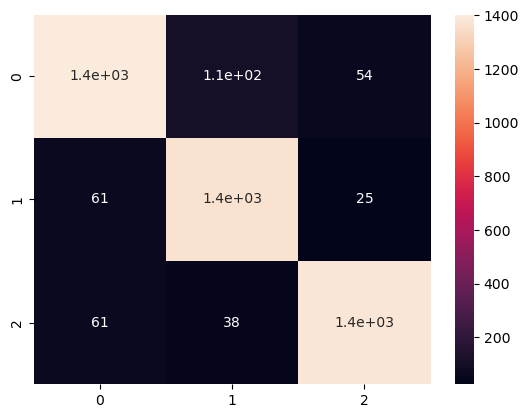

In [8]:
torch.cuda.empty_cache()

vgg13 = vgg13_with_dropout_batchnorm(num_class=3)
vgg13.to(DEVICE)
criterion = nn.CrossEntropyLoss()
optim = torch.optim.SGD(vgg13.parameters(), lr = 0.01)
trainer = Trainer()

vgg13,history = trainer.train(vgg13, optim, criterion, \
                              train_dataloader = train_dataloader, \
                              val_dataloader = val_dataloader, \
                              test_dataloader = test_dataloader, \
                              epochs = 5)

trainer.performance_plot(history)

torch.save(vgg13, 'vgg13.h5')

trainer.confusion_matrix(vgg13, test_dataloader, DEVICE)